# Cefron Analytical Solutions to the GS equation

## Introduction
Cefron found analytical solutions to the Grad-Shafranov equation. We are going to cover the important aspects of his derivation and compare process/solution of his approach to that of PINN's approach. <br>
Here's the Grad-Shafranov equation: <br>
$$ 

R\frac{\partial}{\partial R}
                        \left(
                            \frac{1}{R}
                            \frac{\partial \Psi}{\partial R}
                        \right)\,
                        +\, 
                        \frac{\partial^2 \Psi}{\partial Z^2}\,
                        =\,
-\mu_{0}R^2\frac{dp}{d\Psi}-F\frac{dF}{d\Psi}
$$ 
Both p and F are free functions of  $\Psi$ which, along with the boundary conditions, determine the nature of the equilibrium. <br>
Through the normalization $R=R_{0}x, Z=R_{0}y$, and $\Psi = \Psi_{0}\psi$ where $R_{0}$ is the major radius of the palsma and $\Psi_{0}$ is an arbitrary constant. GS equation becomes:
$$ 

x\frac{\partial}{\partial x}
                        \left(
                            \frac{1}{x}
                            \frac{\partial \Psi}{\partial x}
                        \right)\,
                        +\, 
                        \frac{\partial^2 \Psi}{\partial y^2}\,
                        =\,
-\mu_{0}\frac{R_{0}^4}{\Psi_{0}^2}x^2\frac{dp}{d\Psi}-\frac{R_{0}^2}{\Psi_{0}^2}F\frac{dF}{d\Psi}
 $$ 
Now we are going to choose Solov'ev profiles:
$$
-\mu_{0}\frac{R_{0}^4}{\Psi_{0}^2}x^2\frac{dp}{d\Psi}\,
    = C 
$$
$$
\frac{R_{0}^2}{\Psi_{0}^2}F\frac{dF}{d\Psi}\,
    = A
$$

Now let's look at the boundary constrations and boundary cross section. The parametric equations for the boundary cross section are:
$$
x = 1 + \varepsilon \cos(\tau+\alpha \sin\tau) \\
y = \varepsilon\kappa\sin(\tau)
$$
$\tau$ is a parameter covering the range $0\leq\tau\leq 2\pi$. $\varepsilon$ is the inverse aspect ratio $a/R_{0}$, $\kappa$ is the elongation, and $\sin\alpha = \delta$ is the triangularity. For convex plasma surfaces the triangularity is limited to the range $\delta\leq\sin(1)\approx0.841$. <br>
Let's plot this parametric equations.

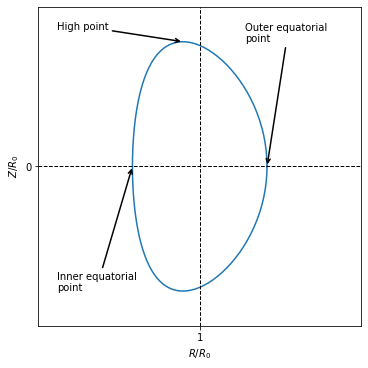

In [2]:
# Plotting the boundary of the cross section
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
plt.rcParams['figure.dpi'] = 100

fig, ax = plt.subplots(1, 1, figsize=(5, 5), constrained_layout=1)

eps = 0.25
delta = 0.25
kappa = 2.5

# Prepare arrays x, y, z
tau = np.linspace(0 , 2 * np.pi, 100)
x = 1 + eps*np.cos(tau+np.arcsin(delta)*np.sin(tau))
y = eps * kappa * np.sin(tau)

ax.plot(x, y)
ax.axhline(y=0.0, linestyle='--', linewidth=1, color='black')
ax.axvline(x=1.0, linestyle='--', linewidth=1, color='black')
ax.axis(xmin=0.4,xmax=1.6,ymin=-0.8, ymax=0.8)
x_ticks = np.array([1])
ax.set_xticks(x_ticks)
y_ticks = np.array([0])
ax.set_yticks(y_ticks)

# Axis Label
ax.set_xlabel("$R/R_{0}$")
ax.set_ylabel("$Z/R_{0}$")


# Annotate
plt.annotate('High point',xy=(1-delta*eps,kappa*eps),xytext=((1-delta*eps)*0.5,(kappa*eps)*1.1),
             arrowprops=dict(arrowstyle='->',lw=1.5))
plt.annotate('Inner equatorial \npoint',xy=(1-eps,0),xytext=((1-delta*eps)*0.5,-kappa*eps*1.0),
             arrowprops=dict(arrowstyle='->',lw=1.5))
plt.annotate('Outer equatorial \npoint',xy=(1+eps,0),xytext=((1+delta*eps)*1.1,+kappa*eps*1.0),
             arrowprops=dict(arrowstyle='->',lw=1.5))


plt.show()

## ITER
Now that we have set up the underlying parameter and concepts. Let's apply the boundary constraints and the shape parameters to find the analytical solution. The baseline design of the ITER has the following parameters: $\varepsilon = 0.32$, $\kappa = 1.7$, and $\delta = 0.33$. 

### Analytical Solution

In [3]:
from gs_solovev_sol import *
# tokamak = GS_Linear(A=-0.155, eps= 2/6.2, kappa=1.6, delta=0.4)
ITER = GS_Linear(A=-0.155, eps= 0.32, kappa=1.7, delta=0.33)

# make mesh
nx = 300
ny = 300
x, y = np.meshgrid(
    np.append(np.linspace(1 - ITER.eps, 1 + ITER.eps, nx),
            np.linspace(-(1 - ITER.eps), -(1 + ITER.eps), nx)),
    np.linspace(-ITER.kappa * ITER.eps, ITER.kappa * ITER.eps, ny),
)

X = np.vstack((np.ravel(x), np.ravel(y))).T

psi_true = ITER.visualize(X,nx,ny*2)
psi_true
psi_true[psi_true>0] = 0.000

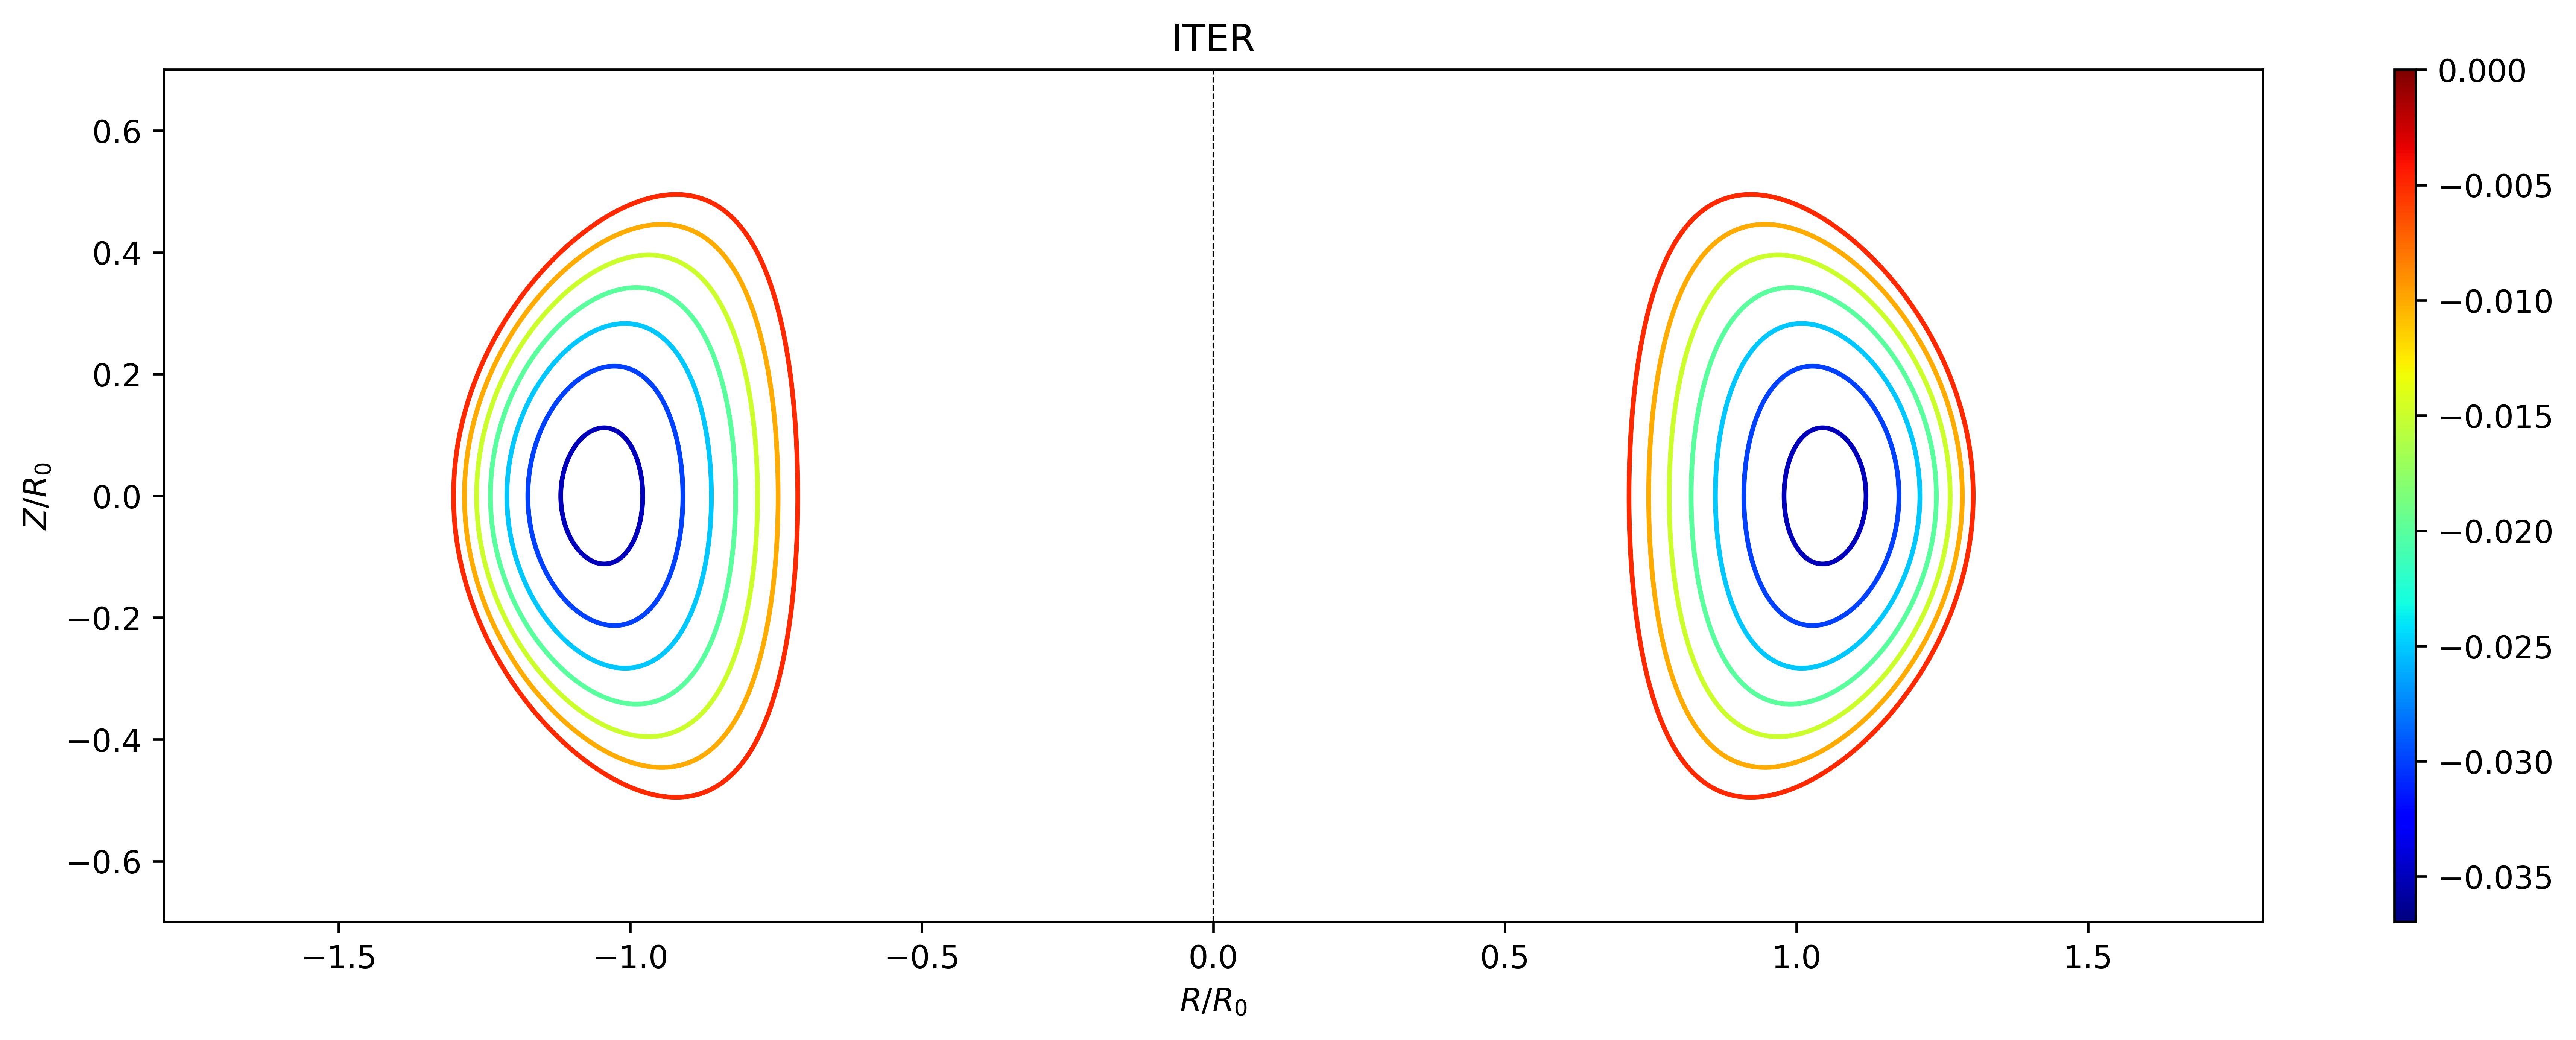

In [4]:
from matplotlib.pyplot import colorbar, Normalize, show, subplots
from matplotlib.cm import ScalarMappable, jet, inferno
plt.rcParams['figure.dpi'] = 600

# Plot psi_true
fig,ax=plt.subplots(1,1,figsize=(15,5))
norm = Normalize(vmin=np.min(psi_true), vmax=0)
cmap = jet
sm = ScalarMappable(cmap=cmap, norm=norm)
cp = ax.contour(x, y, psi_true,norm=norm,cmap=cmap)

ax.set_title('ITER')
ax.set_xlabel('$R/R_{0}$')
ax.set_ylabel('$Z/R_{0}$')
ax.axis(xmin=-1.8,xmax=1.8,ymin=-0.7, ymax=0.7)
ax.axvline(x=0.0, linestyle='--', linewidth=0.5, color='black')

colorbar(sm, aspect=40)
plt.show()



### PINN Solution

#### Setup

In [5]:
from utils import *
model = create_model()
# Compile, train and load model
model.compile("adam", lr=0)
model.restore("./runs/run01/model/ITER-01.ckpt-10000", verbose=1)

Using TensorFlow 2 backend.

Instructions for updating:
non-resource variables are not supported in the long term
Compiling model...
Building feed-forward neural network...
'build' took 0.051616 s



/Users/chrisjang/Documents/UMD/Research/MHD/PINN/deepxde_copy/deepxde/maps/fnn.py:105: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2022-08-09 16:08:23.868589: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


'compile' took 0.606149 s

Restoring model from ./runs/run01/model/ITER-01.ckpt-10000 ...

INFO:tensorflow:Restoring parameters from ./runs/run01/model/ITER-01.ckpt-10000


2022-08-09 16:08:24.436052: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


In [6]:
N = 1001
eps, kappa, delta = ITER.eps, ITER.kappa, ITER.delta
tau = np.linspace(0, 2 * np.pi, N)
# Define boundary of ellipse
x_ellipse = np.asarray([1 + eps * np.cos(tau + np.arcsin(delta) * np.sin(tau)), 
                eps * kappa * np.sin(tau)]).T[::-1]


In [7]:
# make mesh
nx = 500
ny = 500
zoom = 0.0

x, y = np.meshgrid(
    np.linspace(0.575,1.625, nx),
    np.linspace(-0.6,0.6, ny),
)
X = np.vstack((np.ravel(x), np.ravel(y))).T

X_bc = np.vstack((np.ravel(x_ellipse[:,0]), np.ravel(x_ellipse[:,1]))).T
output_bc_pred = model.predict(X_bc).reshape(-1)
output_bc_true = []
for point in X_bc:
    output_bc_true.append(ITER.psi_func(point[0],point[1]))

# Calculate corresponding psi
psi_true_lin = []
for point in X:
    psi_true_lin.append(ITER.psi_func(point[0],point[1]))
#filter
psi_true_lin = np.array(psi_true_lin)
psi_true_lin[psi_true_lin>max(output_bc_true)] = 0.000

psi_true = np.reshape(psi_true_lin, [nx, ny])
psi_pred_lin = model.predict(X)
psi_pred_lin = psi_pred_lin.reshape(-1)
#filter
psi_pred_lin[psi_pred_lin>max(output_bc_pred)] = max(output_bc_pred)

psi_pred = np.reshape(psi_pred_lin, [nx, ny])


#filter
e_max = max((output_bc_pred-np.array(output_bc_true))**2/min(output_bc_pred)**2)

e = (psi_pred_lin-np.array(psi_true_lin))**2/min(psi_pred_lin)**2
error = np.reshape(e, [nx, ny])
error[error>e_max] = e_max



#### Relative Error Plot

(500, 500)


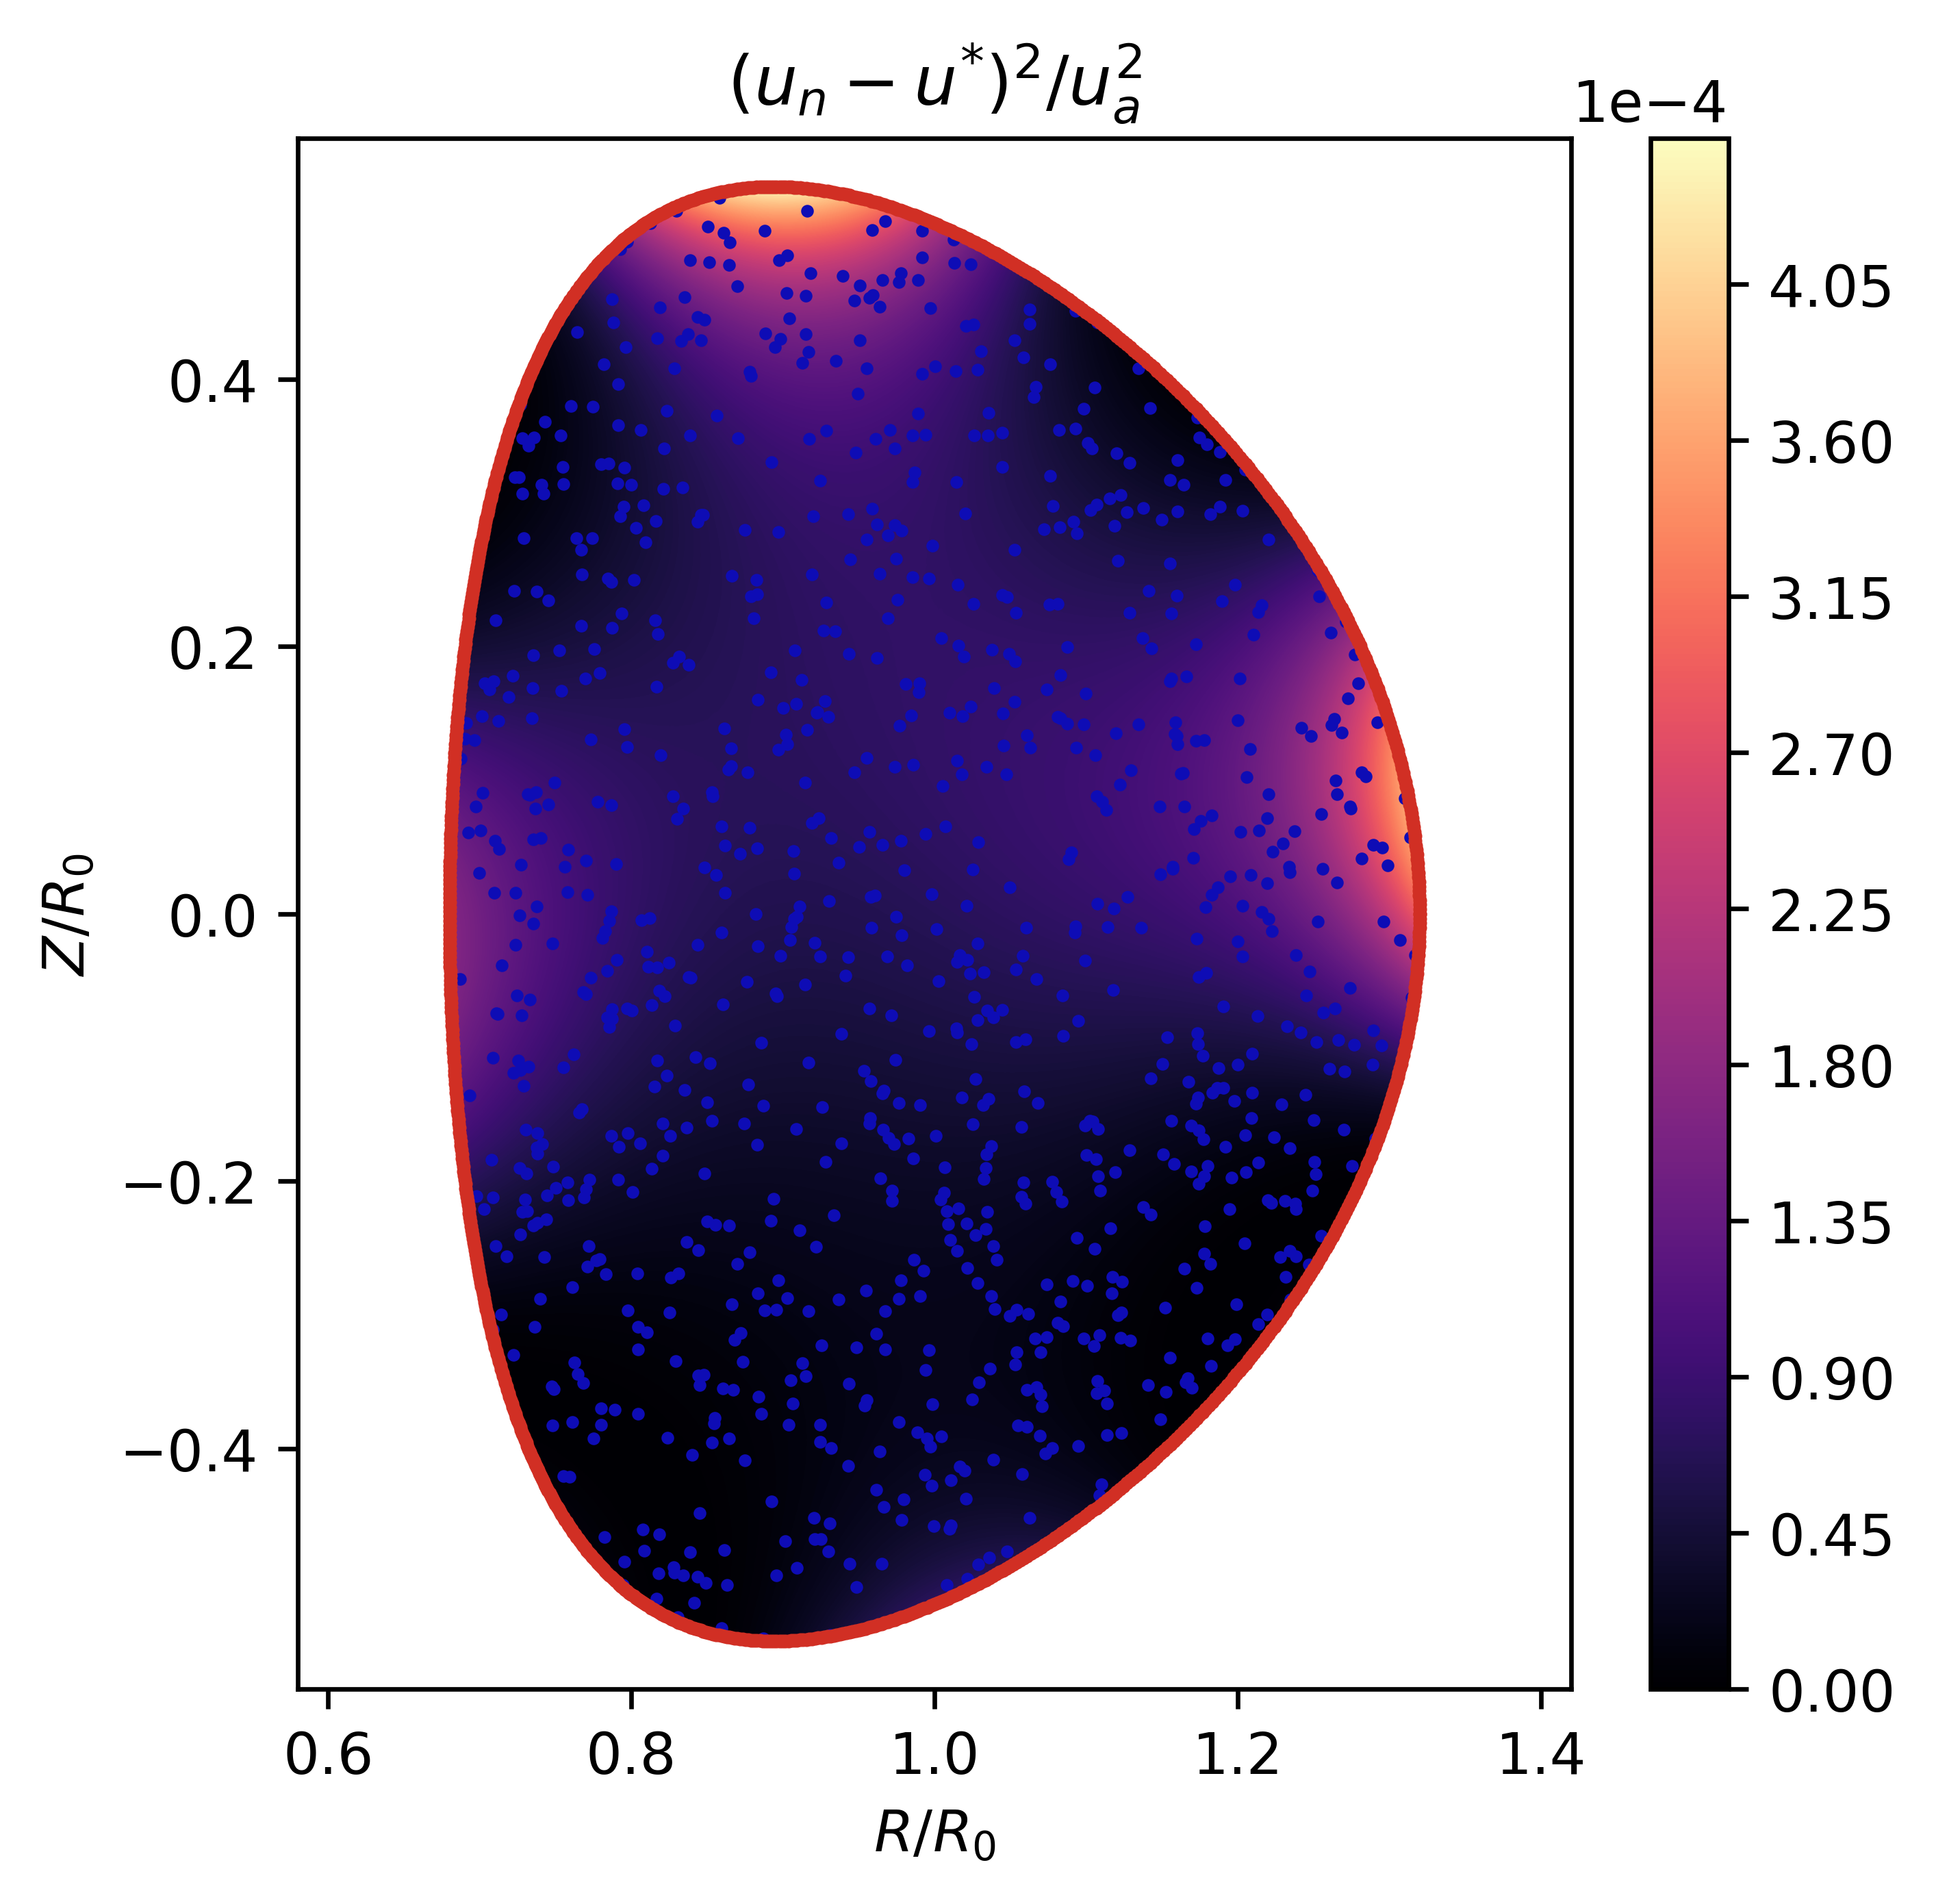

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

print(psi_pred.shape)

levels = 1000
cmap= plt.cm.get_cmap("magma", levels+1)

fig,ax=plt.subplots(1,1,figsize=(5,5))
cp = ax.contourf(x, y, error,levels, cmap=cmap)

# Inside
plt.scatter(model.data.train_x[:,0], model.data.train_x[:,1], s = 1.5, c="#0E0CB5")

# Boundary
ax.scatter(model.data.bc_points()[:,0], model.data.bc_points()[:,1], s = 2,c="#D12F24")


cb = fig.colorbar(cp) # Add a colorbar to a plot
cb.formatter.set_powerlimits((0, 0))
cb.ax.yaxis.set_offset_position('right')
cb.update_ticks()

ax.set_title(r'$(u_{n}-u^{*})^2/u_{a}^2$')
ax.set_xlabel(r'$R/R_{0}$')
ax.set_ylabel(r'$Z/R_{0}$')

circ = patches.Polygon(xy=X_bc, transform=ax.transData)
for coll in cp.collections:
    coll.set_clip_path(circ)


ax.axis(xmin=0.58,xmax=1.42,ymin=-0.58, ymax=0.58)

plt.show()



In [10]:
# Get equatorial plane y = 0
x_eq, y_eq = np.meshgrid(
    np.linspace(1 - eps*(1+zoom), 1 + eps*(1+zoom), nx),
    np.linspace(0,0, 1),
)
X_eq = np.vstack((np.ravel(x_eq), np.ravel(y_eq))).T
# Calculate corresponding psi
psi_eq = []
for point in X_eq:
    psi_eq.append(ITER.psi_func(point[0],point[1]))
psi_true_eq = np.reshape(psi_eq, [500, 1])
output_eq = model.predict(X_eq)
psi_pred_eq = output_eq[:, 0].reshape(-1)
psi_pred_eq = np.reshape(psi_pred_eq, [nx, 1])


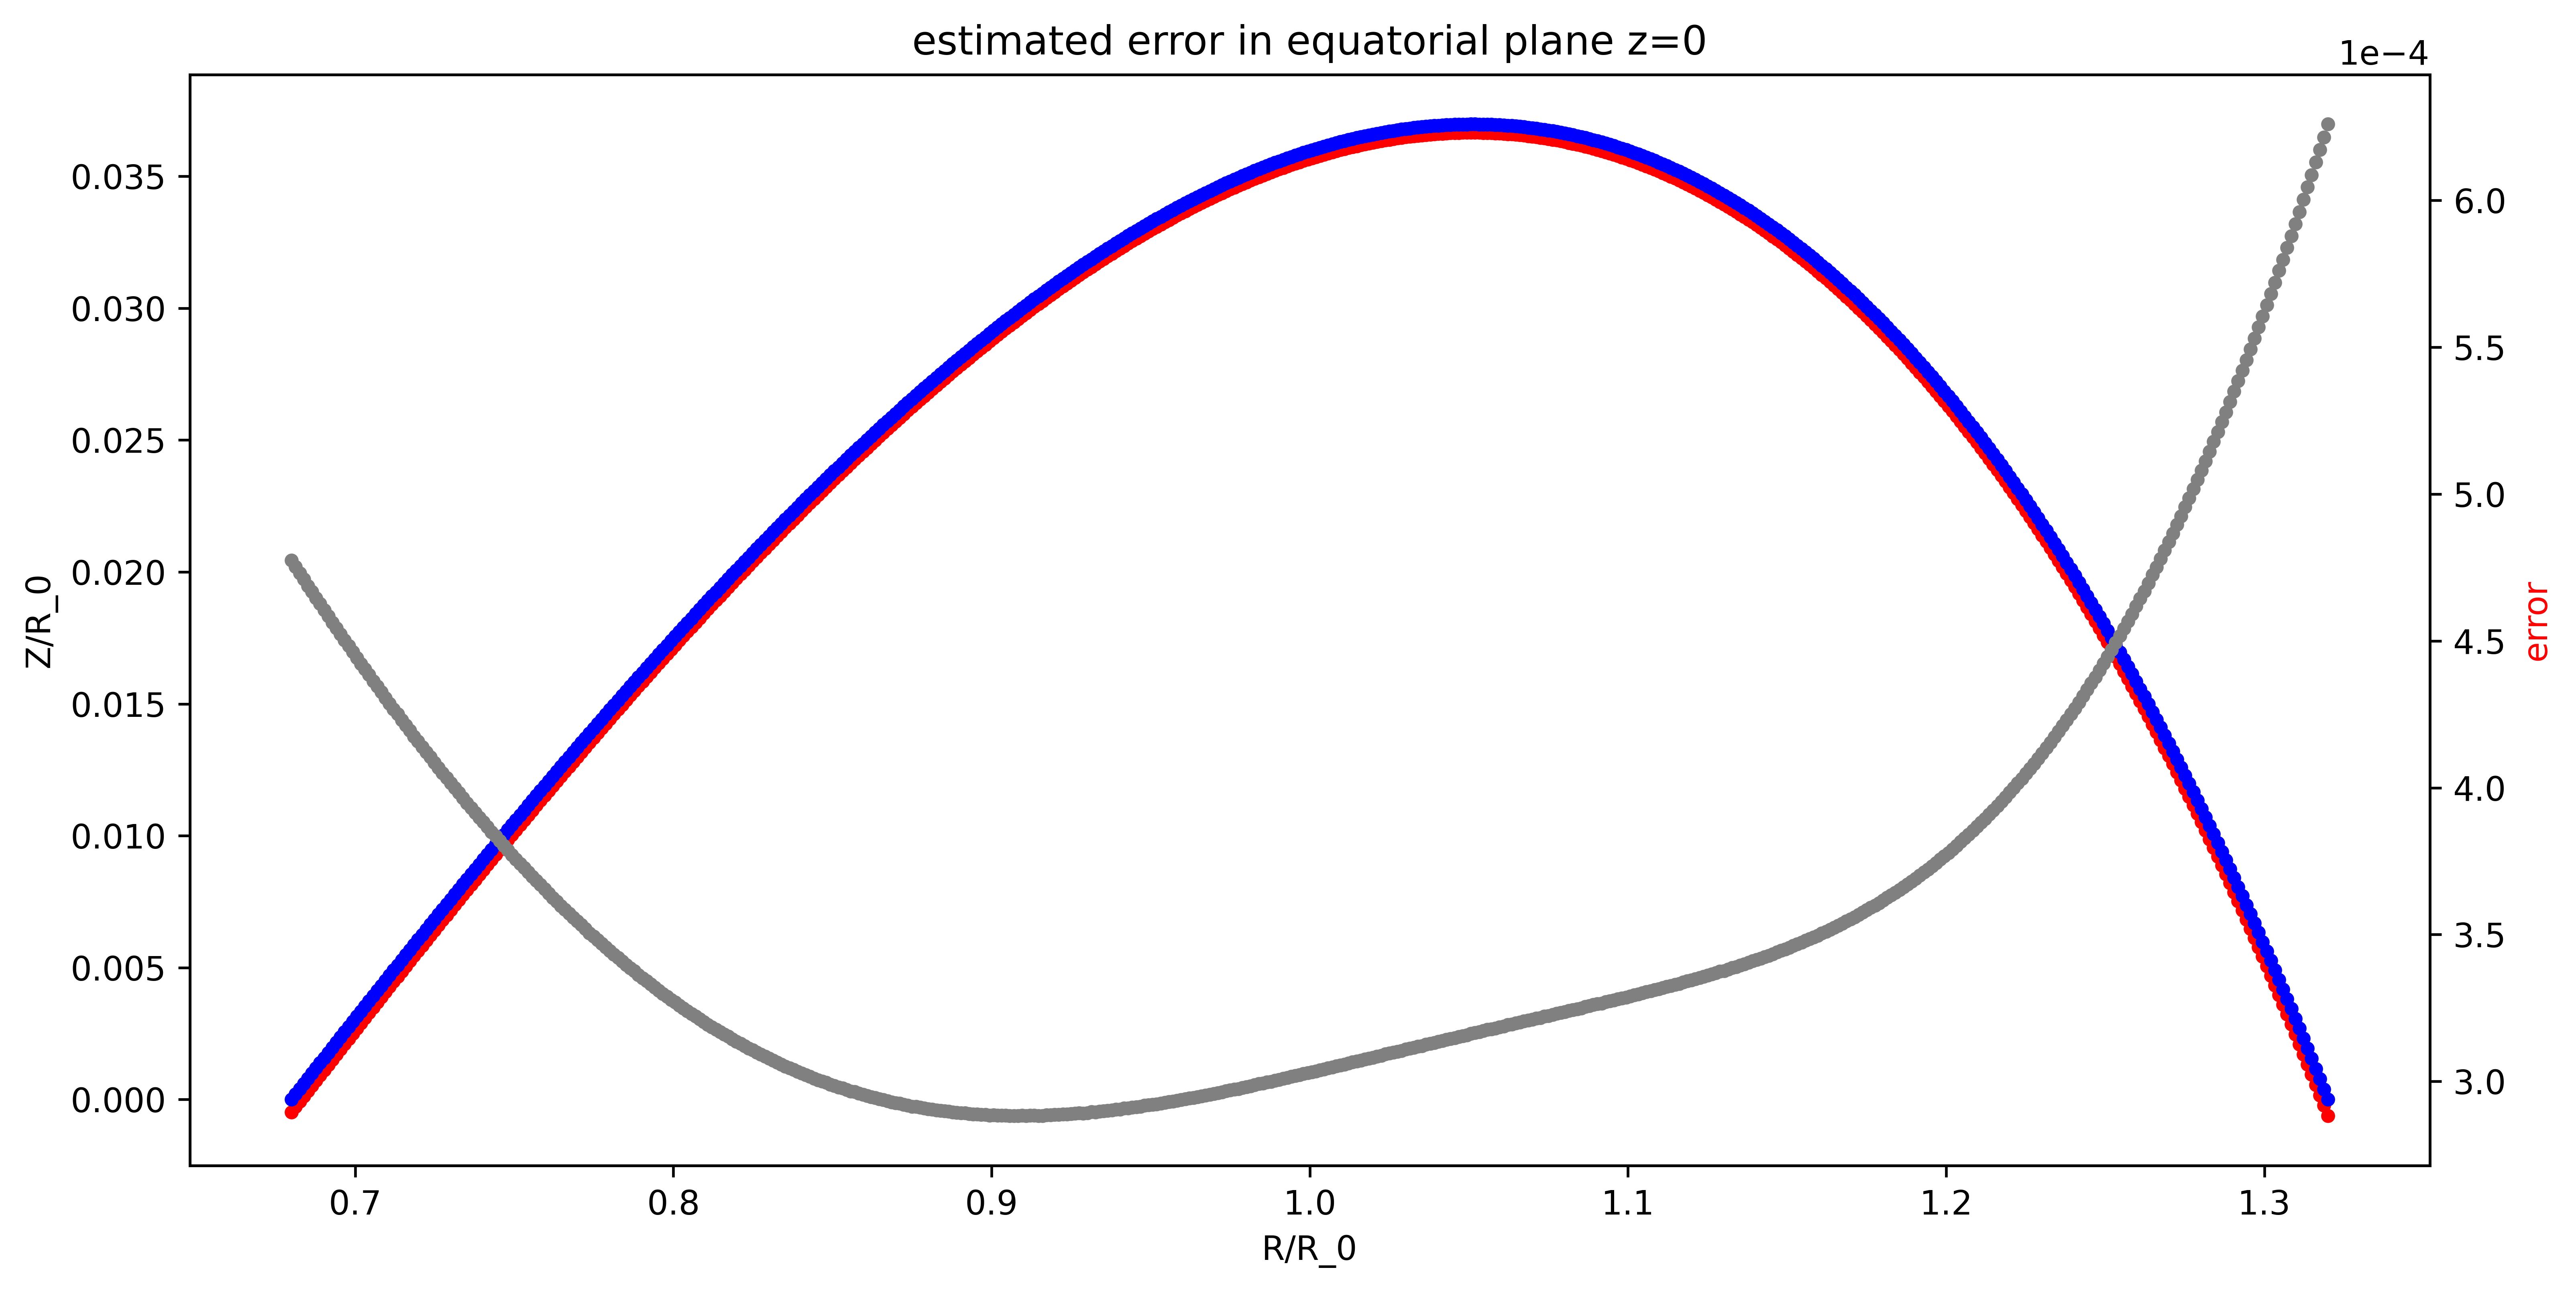

In [15]:
# comparison of the Solovev neural network with the analytic solution on the equatorial plane z = 0.
fig,ax=plt.subplots(1,1,figsize=(12,6))
ax2 = ax.twinx()
ax.scatter(x_eq, -psi_pred_eq, s = 10,c="red")
ax.scatter(x_eq, -psi_true_eq, s = 10,c="blue")
ax2.scatter(x_eq, -(psi_true_eq-psi_pred_eq), s = 10,c="grey")
ax2.yaxis.get_major_formatter().set_scientific(True)

ax.set_title('estimated error in equatorial plane z=0')
ax.set_xlabel('R/R_0')
ax.set_ylabel('Z/R_0')
ax2.set_ylabel('error', color='red')

plt.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
plt.show()


#### MISC Plotting

(500, 500)


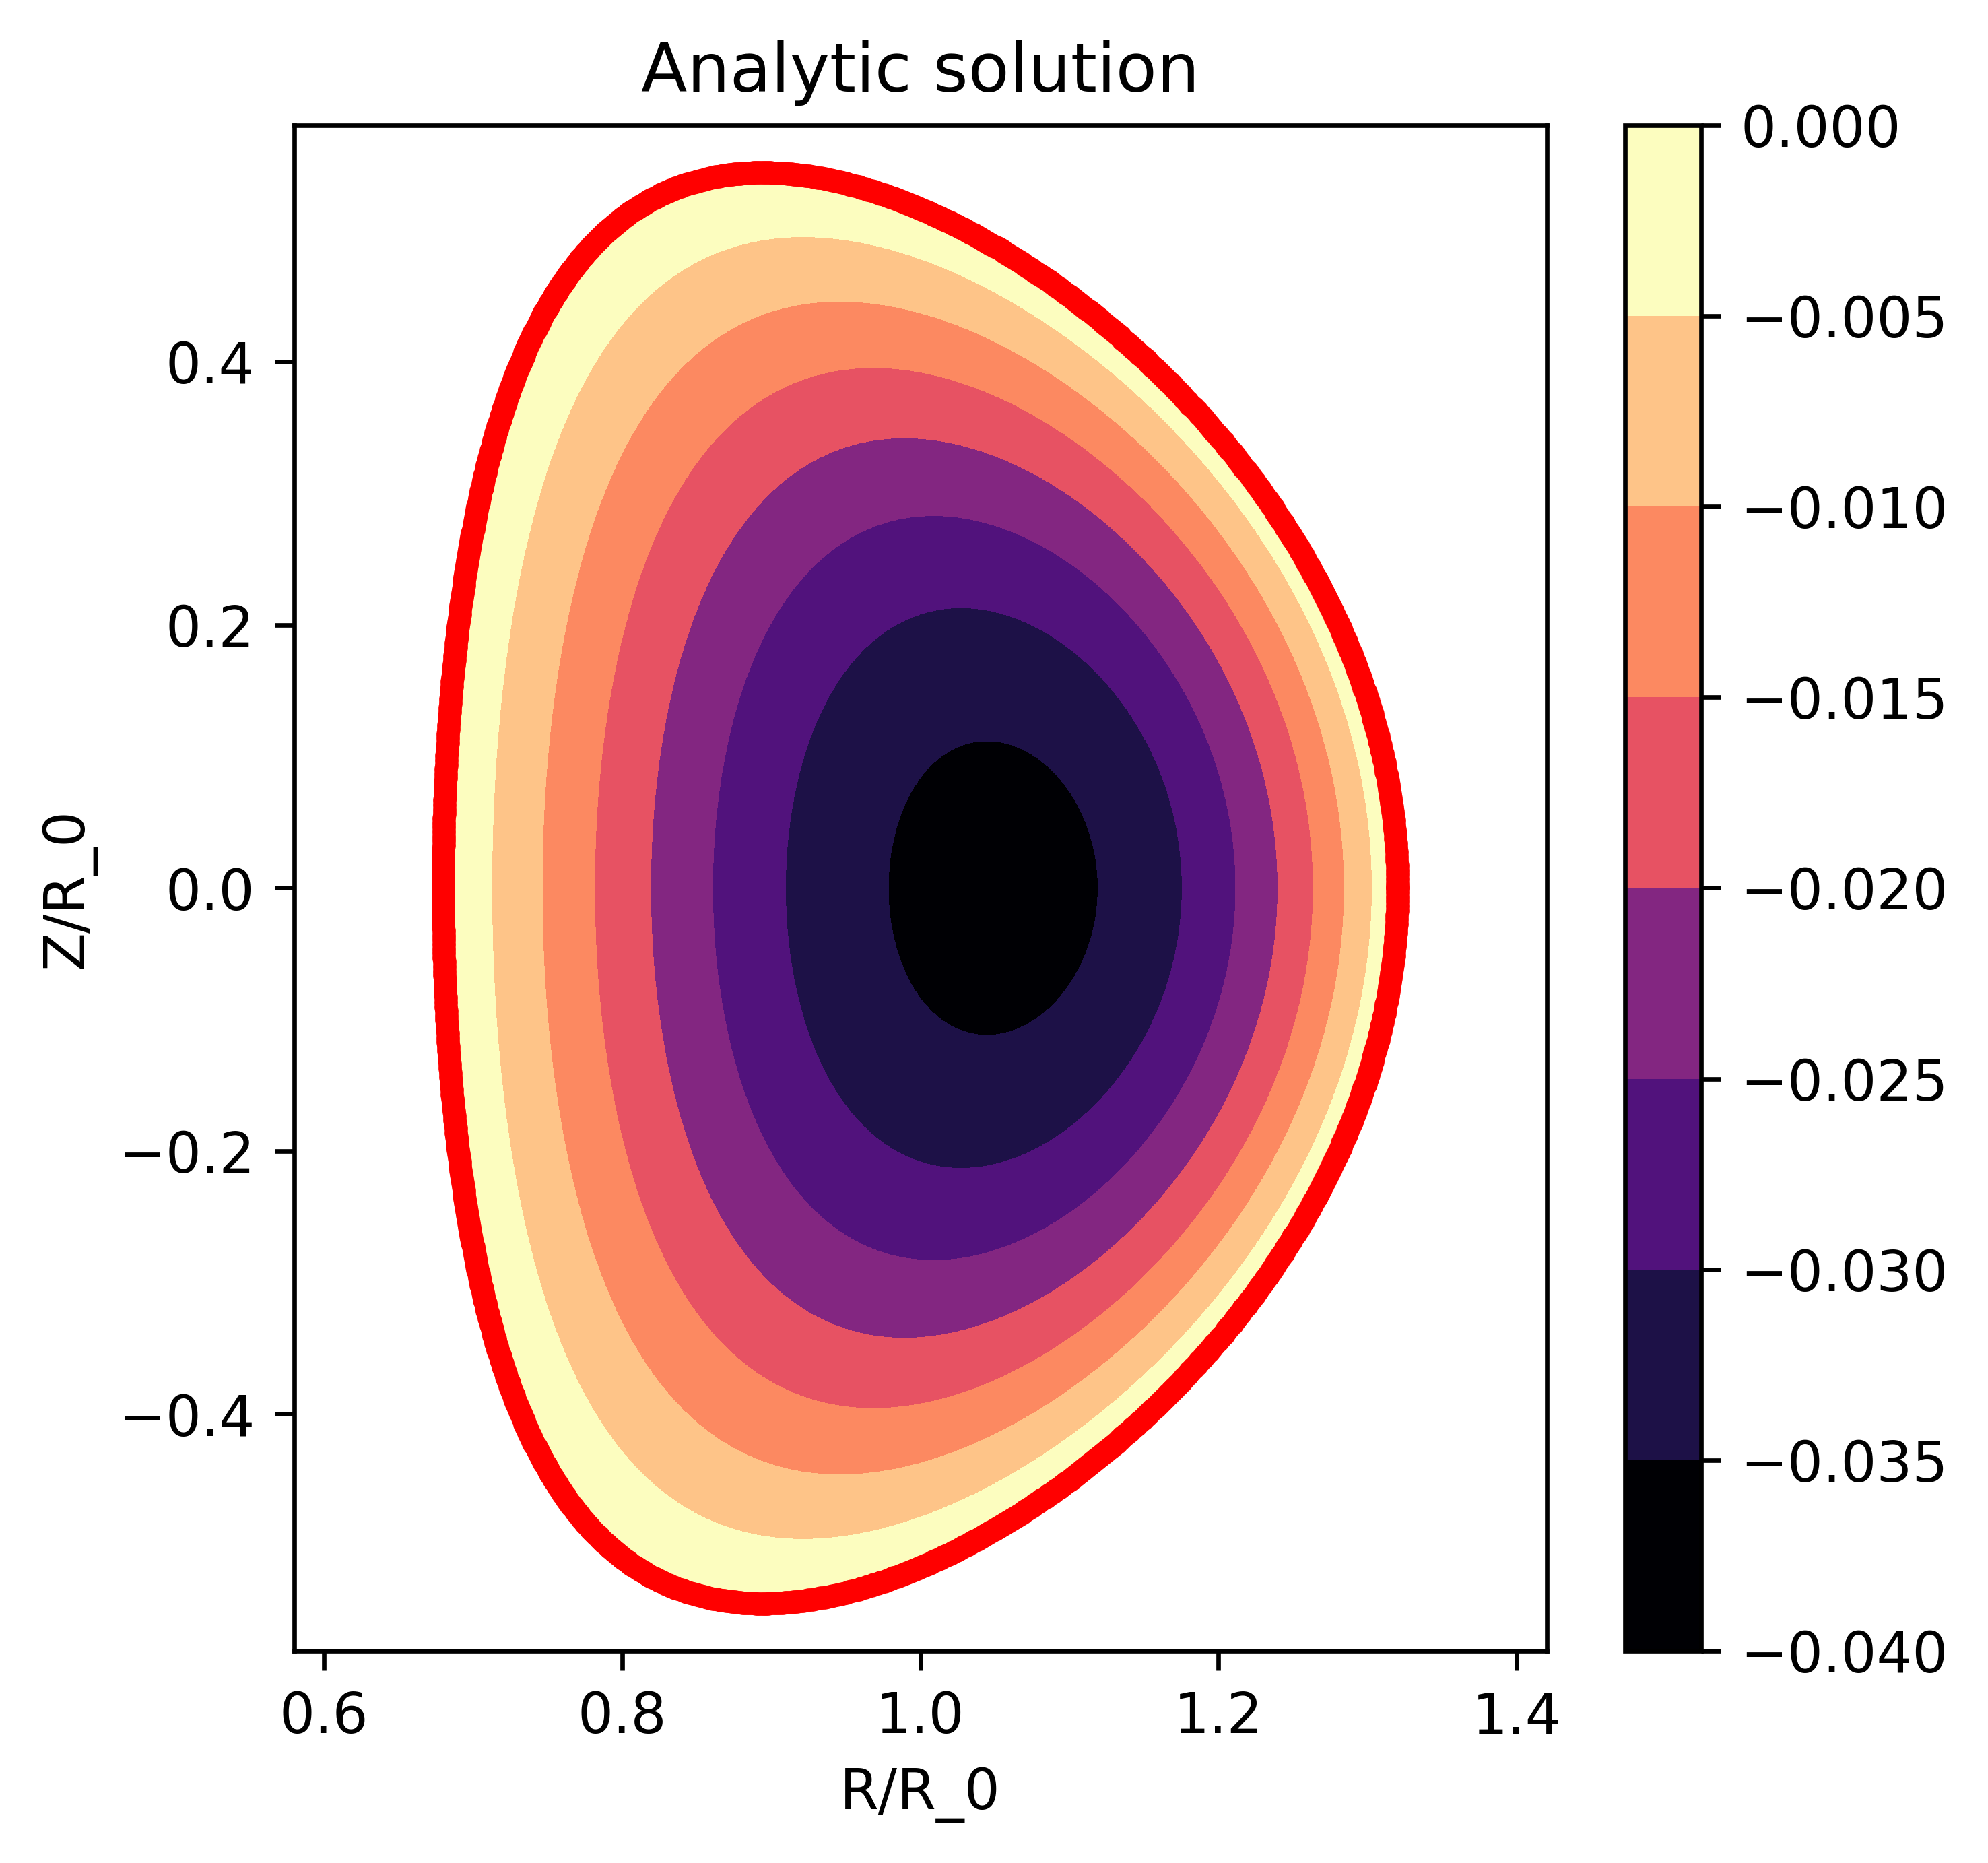

In [ ]:
print(psi_pred.shape)

levels = 8
cmap= plt.cm.get_cmap("magma", levels+1)

fig,ax=plt.subplots(1,1,figsize=(5,5))
cp = ax.contourf(x, y, psi_true,levels, cmap=cmap)
ax.scatter(model.data.bc_points()[:,0], model.data.bc_points()[:,1], s = 10,c="red")
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Analytic solution')
ax.set_xlabel('R/R_0')
ax.set_ylabel('Z/R_0')

circ = patches.Polygon(xy=X_bc, transform=ax.transData)
for coll in cp.collections:
    coll.set_clip_path(circ)


ax.axis(xmin=0.58,xmax=1.42,ymin=-0.58, ymax=0.58)

plt.show()



(500, 500)


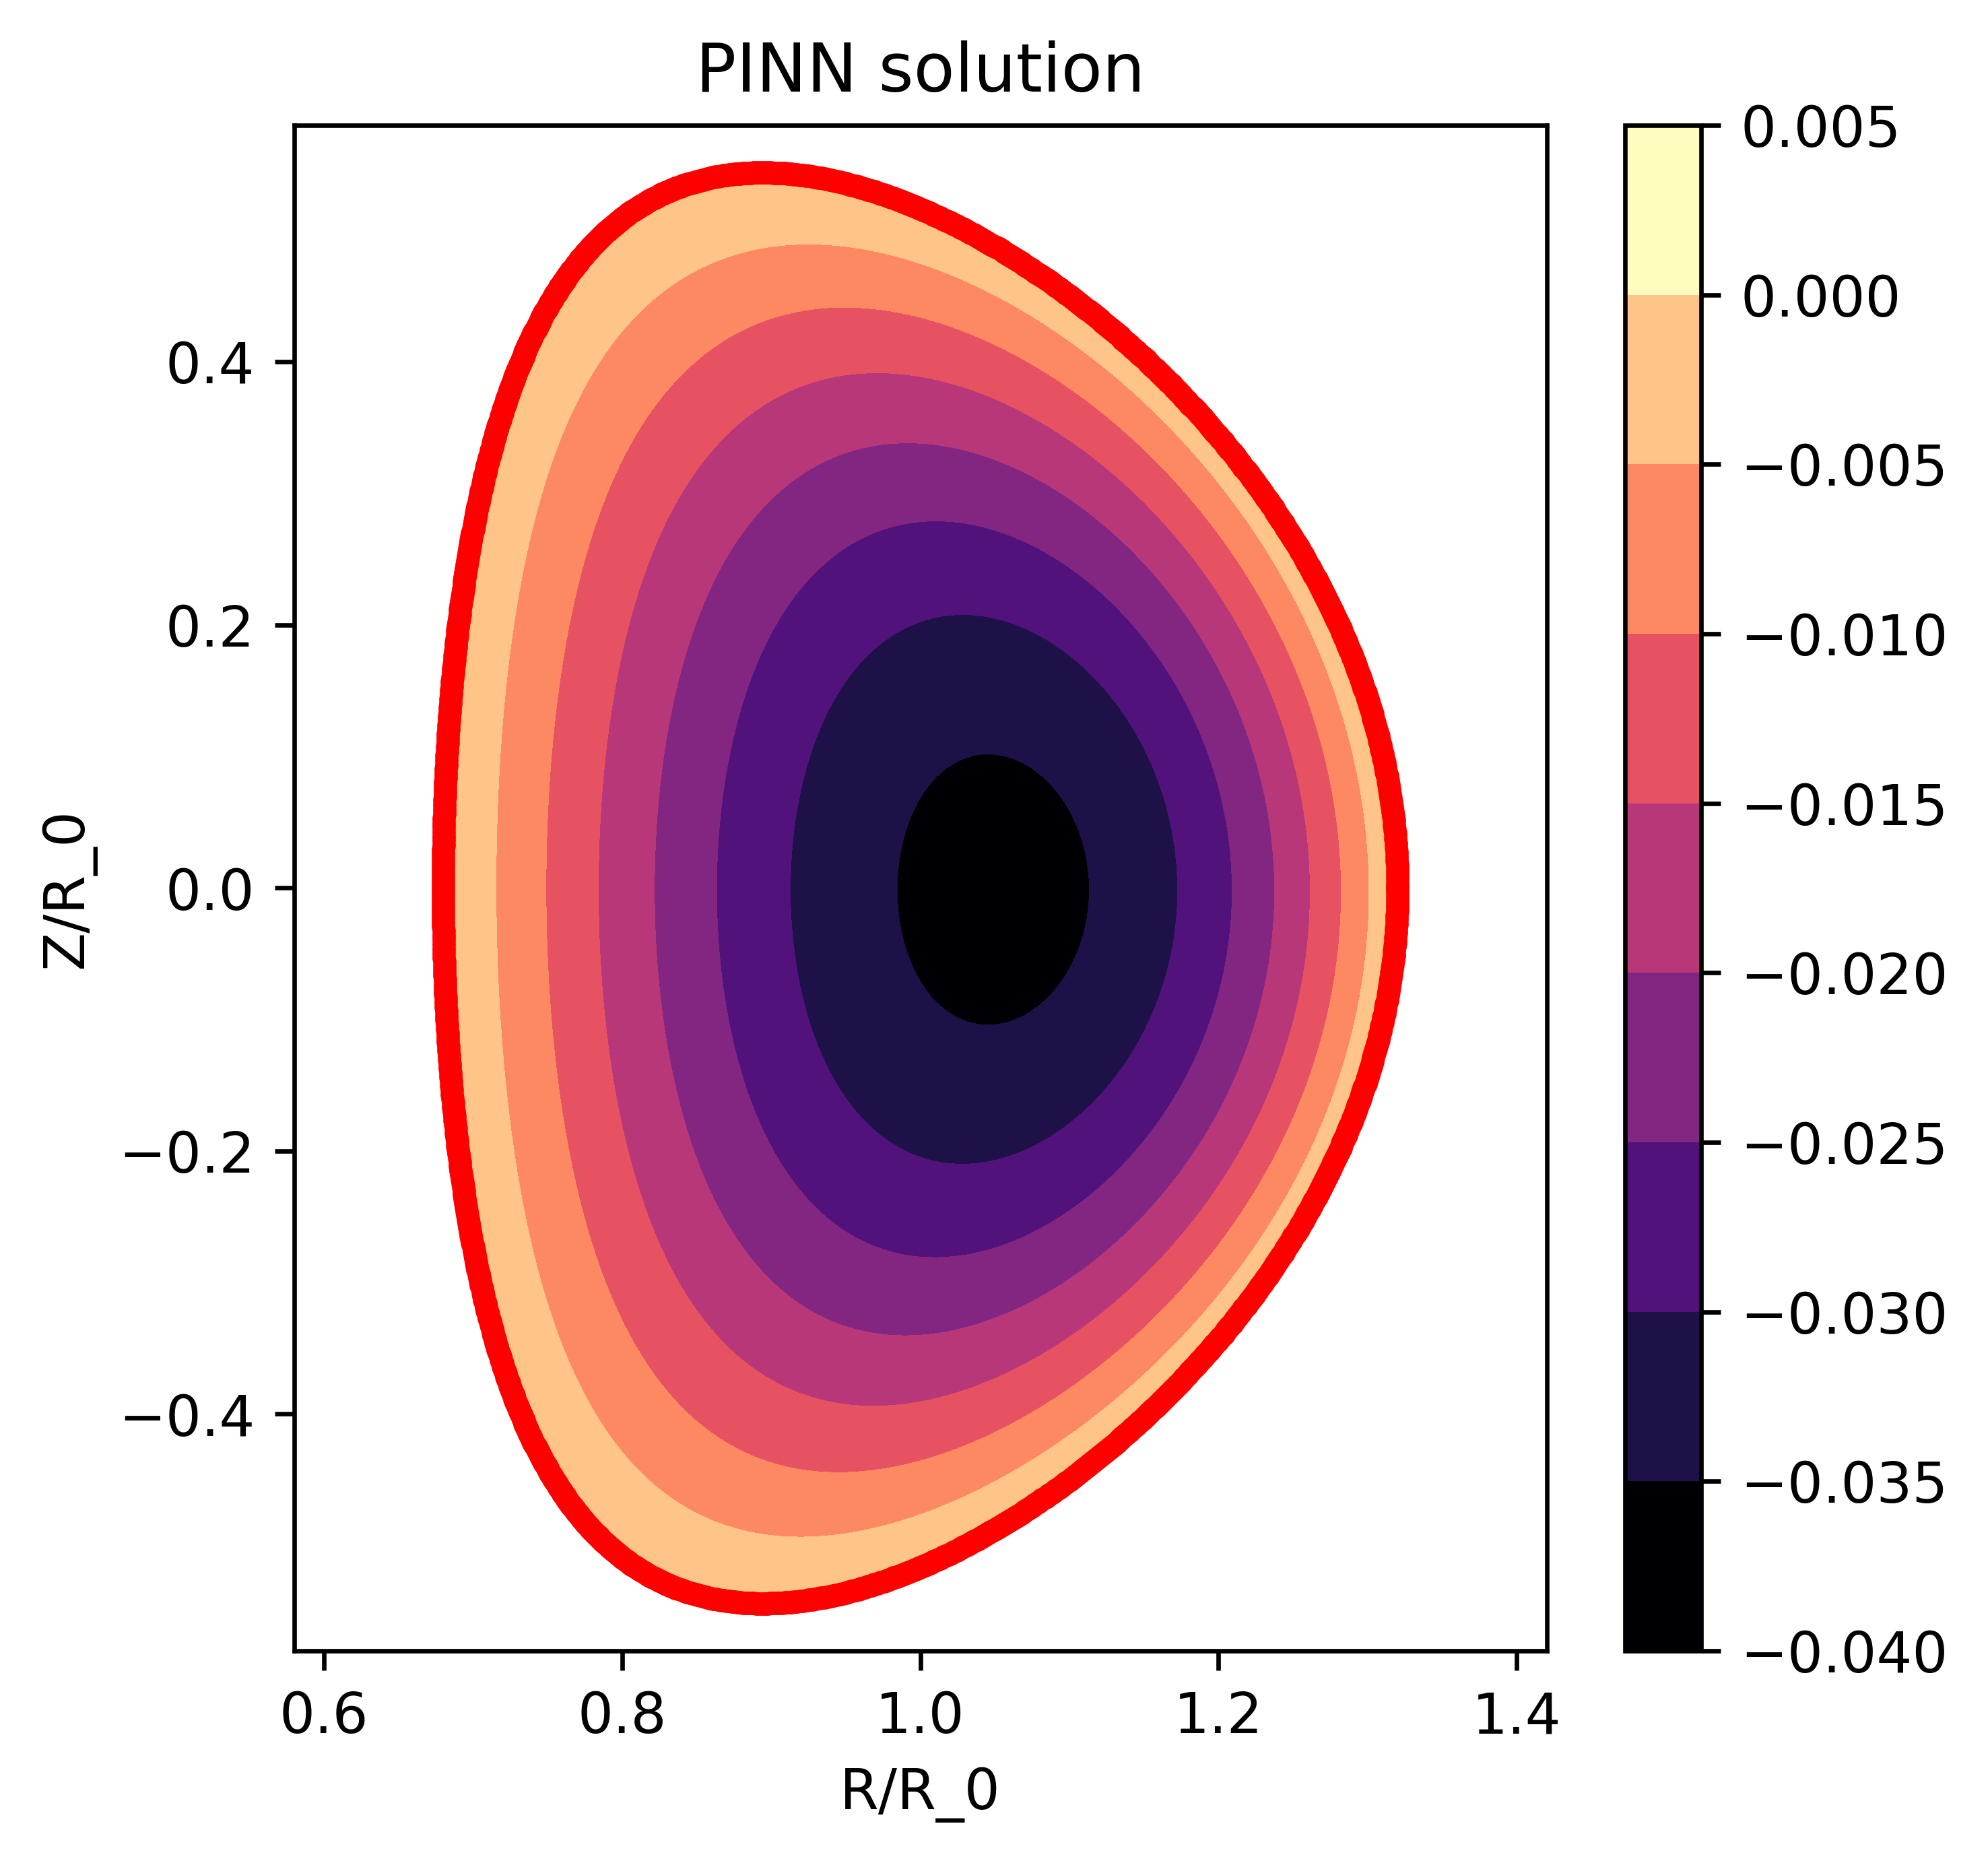

In [ ]:
print(psi_pred.shape)

levels = 8
cmap= plt.cm.get_cmap("magma", levels+1)

fig,ax=plt.subplots(1,1,figsize=(5,5))
cp = ax.contourf(x, y, psi_pred,levels, cmap=cmap)
ax.scatter(model.data.bc_points()[:,0], model.data.bc_points()[:,1], s = 10,c="red")
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('PINN solution')
ax.set_xlabel('R/R_0')
ax.set_ylabel('Z/R_0')

circ = patches.Polygon(xy=X_bc, transform=ax.transData)
for coll in cp.collections:
    coll.set_clip_path(circ)


ax.axis(xmin=0.58,xmax=1.42,ymin=-0.58, ymax=0.58)


plt.show()

